In [1]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
train_dir = 'train'
SPEC1 = pd.read_csv('train.csv')
train = SPEC1.copy()

In [3]:
print(SPEC1.shape)
SPECIES = (SPEC1['Id'].unique().tolist())
print(len(SPEC1))
print(len(SPEC1['Image'].unique().tolist()))

(9850, 2)
9850
9850


In [4]:
print(SPECIES[:5])

['w_e15442c', 'w_1287fbc', 'w_da2efe0', 'w_19e5482', 'w_f22f3e3']


In [5]:
#for species in SPECIES:
#    print('{} {} images'.format\
#          (species, len(os.listdir(os.path.join(train_dir, species)))))

In [5]:
for i in range(len(train)):
    #train.loc['Image',i] = train[i] 
    train.loc[i,'Image'] = 'train/' + train.loc[i,'Image']
        
#train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)
train['species_num'] = None
print(train.head())
for i in range(len(train)):
    train.loc[i,'species_num'] = SPECIES.index(train.loc[i,'Id'])

Training Data:  (9850, 2)
                Image         Id species_num
0  train/00022e1a.jpg  w_e15442c        None
1  train/000466c4.jpg  w_1287fbc        None
2  train/00087b01.jpg  w_da2efe0        None
3  train/001296d5.jpg  w_19e5482        None
4  train/0014cfdf.jpg  w_f22f3e3        None


In [6]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 99, 99])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [7]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['Image'][i])
    img = cv2.resize(img,dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 1min 3s, sys: 10.3 s, total: 1min 13s
Wall time: 36.6 s


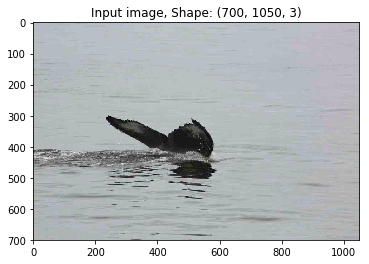

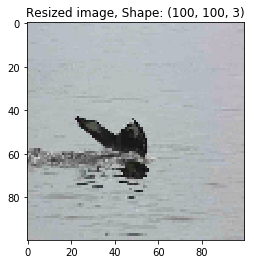

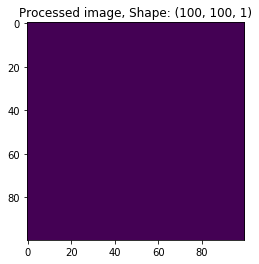

In [8]:
for i in [1]:
    img = cv2.imread(train['Image'][i])
    img = cv2.resize(img,dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
# Input image
Input_image = cv2.imread(train['Image'][i])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(100,100)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [9]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [10]:
print(labels)
print(len(x_train))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
9850


In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, \
                        labels, test_size = 0.1, random_state=10)

In [12]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (100, 100, 4)


In [13]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 16)   1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 48, 48, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 48, 16)   2320        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_3 (

In [14]:
model_new.compile(optimizer = Adam(lr=.00025) ,\
                  loss = 'categorical_crossentropy',\
                  metrics=['accuracy'])

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',\
                patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [16]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, \
                    width_shift_range=0.2, height_shift_range=0.2,\
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

In [19]:
#model_new.load_weights('model_weights_2.h5f')

In [17]:
batch_size = 32
epochs = 1

In [18]:
#Training
history=  model_new.\
fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), \
              epochs = epochs,validation_data = (x_val,y_val), \
              verbose = 1, steps_per_epoch=x_train.shape[0]\
              // batch_size, callbacks=[learning_rate_reduction])

Epoch 1/1
277/277 [==============================] - 198s 714ms/step - loss: 8.1671 - acc: 0.0817 - val_loss: 8.2180 - val_acc: 0.0721


In [22]:
#model_new.save_weights('model_weights_2.h5f', overwrite=True)

In [23]:
'''%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)'''

"%%time\n\ntest = []\nfor file in os.listdir(os.path.join(test_dir)):\n    test.append(['test/{}'.format(file)])\n\ntest = pd.DataFrame(test, columns=['file'])\nprint(test.head(5))\n\n\nx_test = []\n\nfor i in range(len(test)):\n    img = cv2.imread(test['file'][i])\n    img = cv2.resize(img,dsize=(256,256))\n    img_stack = segment_plant(img)\n    img_stack = sharpen_image(img_stack)\n    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )\n    img_stack = np.reshape(img_stack,(256,256,1))\n    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))\n\nx_test = np.array(x_test)"

In [24]:
'''randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()'''

"randm = np.random.randint(0,len(test))\n\nimg = cv2.imread(test['file'][randm])\nplt.imshow(img)\nplt.show()\n\nimg_processed = x_test[randm]\nplt.imshow(img_processed)\nplt.show()"

In [19]:
score = model_new.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

985/985 [==============================] - 6s 6ms/step
Accuracy on Validation Set 0.07208121822872743


In [20]:
model_feat = Model(inputs=model_new.input, outputs=model_new.get_layer\
                  ('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

#feat_test = model_feat.predict(x_test)
#print(feat_test.shape)

(8865, 512)
(985, 512)


In [21]:
svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train, axis=1))

print("Done")


Done


In [ ]:
svm.score(feat_train,np.argmax(y_train,axis=1))

In [22]:
svm.score(feat_val, np.argmax(y_val,axis=1))

0.07208121827411168